In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import csgraph_to_masked
import anndata as ad
import scanpy as sc
from scanpy.neighbors._common import _get_indices_distances_from_sparse_matrix
from scanpy.neighbors._connectivity import umap
from model.ricci_curv import ricciCurvature

/home/bili/Apps/Mamba/envs/cb/lib/python3.11/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
ad_data = ad.read_h5ad("../data/CD4RNA.h5ad")
sc.pp.log1p(ad_data)
sc.pp.highly_variable_genes(ad_data,n_top_genes=500)
sc.pp.normalize_per_cell(ad_data)
ad_data = ad_data[:,ad_data.var.highly_variable]
sc.pp.pca(ad_data)
knn_data = ad_data.copy()
sc.pp.neighbors(knn_data,n_neighbors=30)
knn_graph = knn_data.obsp['distances']
small_knn_data = ad_data.copy()
sc.pp.neighbors(small_knn_data,n_neighbors=10)
knn_graph_small = small_knn_data.obsp['distances']

/home/bili/Apps/Mamba/envs/cb/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


In [3]:
curvature = ricciCurvature(ad_data.X,knn_graph)

196it [00:10, 19.26it/s]


In [4]:
# select indices on knn graph with the highest curvature
graph_mask = csgraph_to_masked(knn_graph)
curvature_masked = graph_mask * curvature
max_curv_indicies = np.argsort(curvature_masked, axis=1)[:,:10]
min_curv_indicies = np.argsort(curvature_masked, axis=1)[:,20:30]
max_curv_graph = sp.sparse.csr_matrix(knn_graph.shape)
min_curv_graph = sp.sparse.csr_matrix(knn_graph.shape)
for i in range(max_curv_indicies.shape[0]):
    max_curv_graph[i,max_curv_indicies[i]] = knn_graph[i,max_curv_indicies[i]]
    min_curv_graph[i,min_curv_indicies[i]] = knn_graph[i,min_curv_indicies[i]]
    

/home/bili/Apps/Mamba/envs/cb/lib/python3.11/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


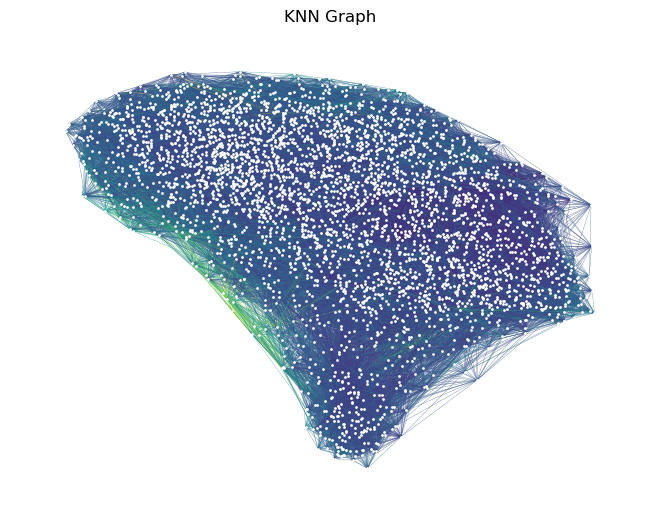

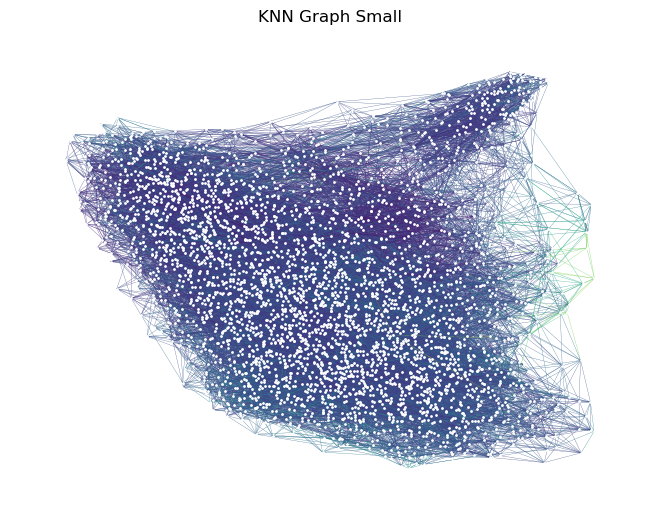

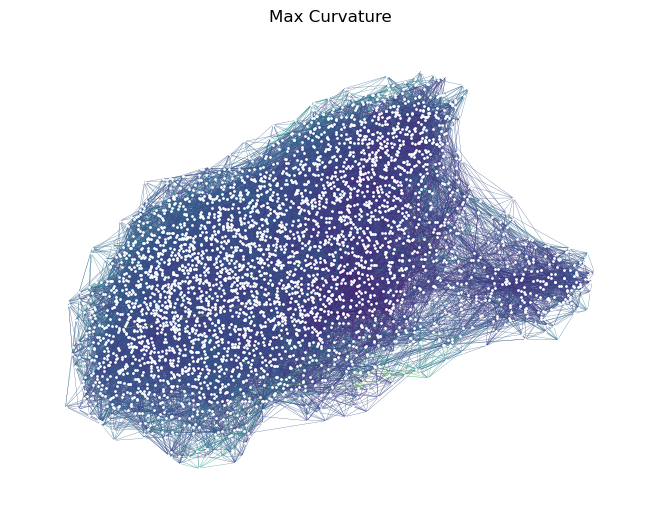

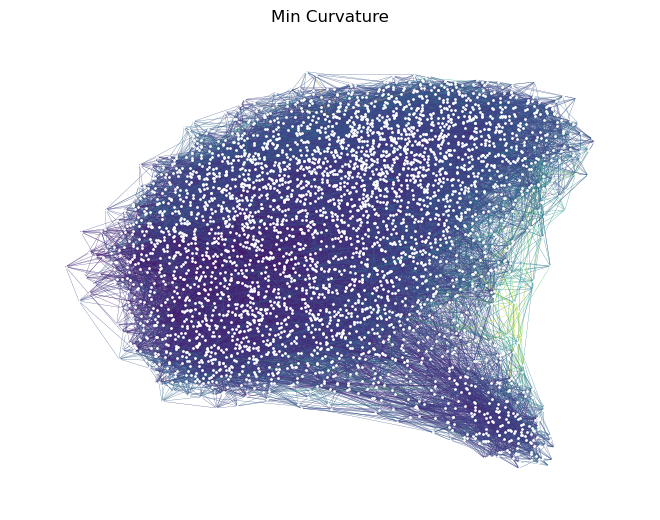

In [5]:
import networkx as nx
def drawGraph(adj):
    graph = nx.from_numpy_array(adj)
    edge_value = nx.get_edge_attributes(graph,'weight')
    edge_value = edge_value.values()
    nx.draw(graph,node_color='white',node_size=1,width=0.2,edge_color=edge_value,edge_cmap=plt.cm.viridis)
    return
for graph,title in zip([knn_graph,knn_graph_small,max_curv_graph,min_curv_graph],["KNN Graph","KNN Graph Small","Max Curvature","Min Curvature"]):
    drawGraph(graph)
    plt.title(title)
    plt.show()

/tmp/ipykernel_1623950/3743683834.py:12: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata=point_ad,resolution=0.5,key_added='clusters')


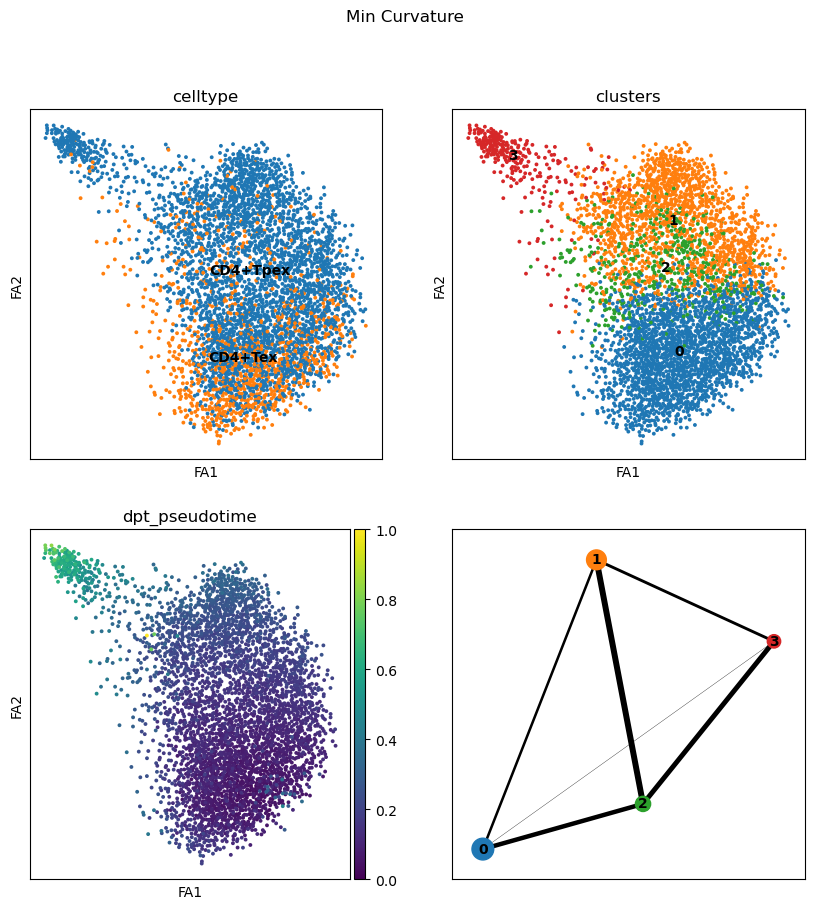

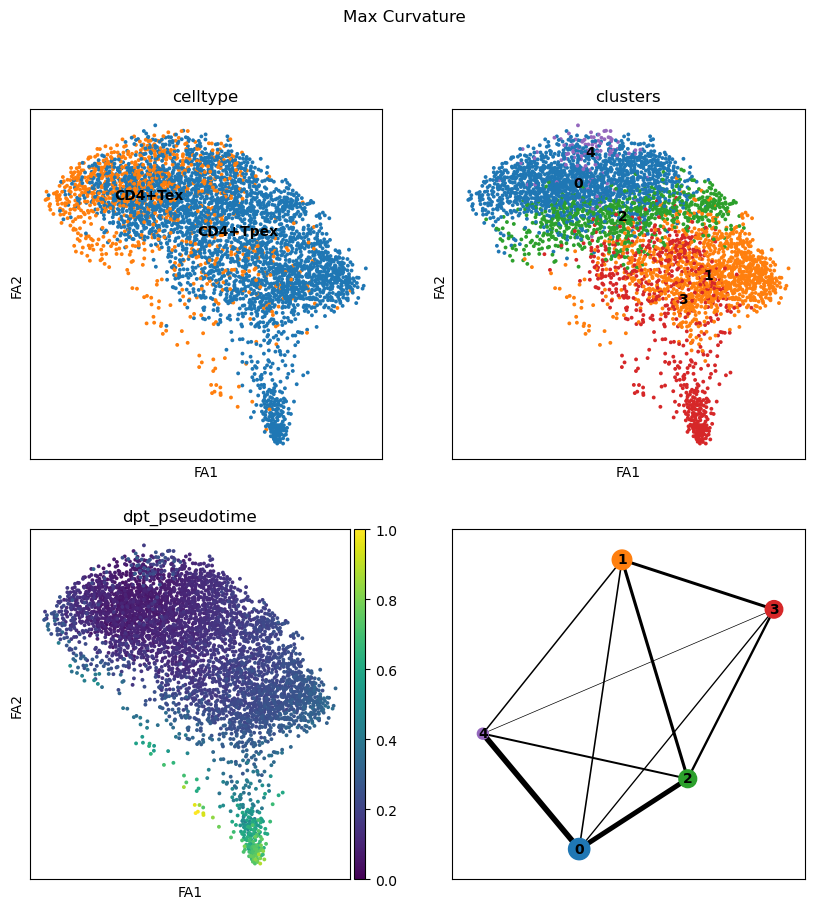

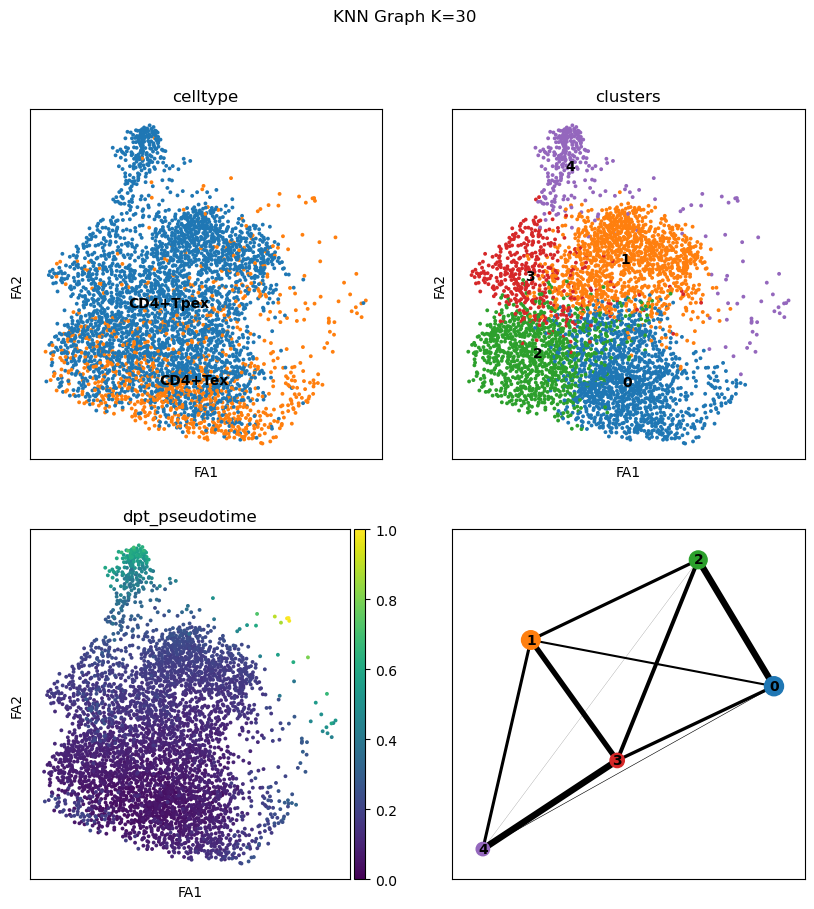

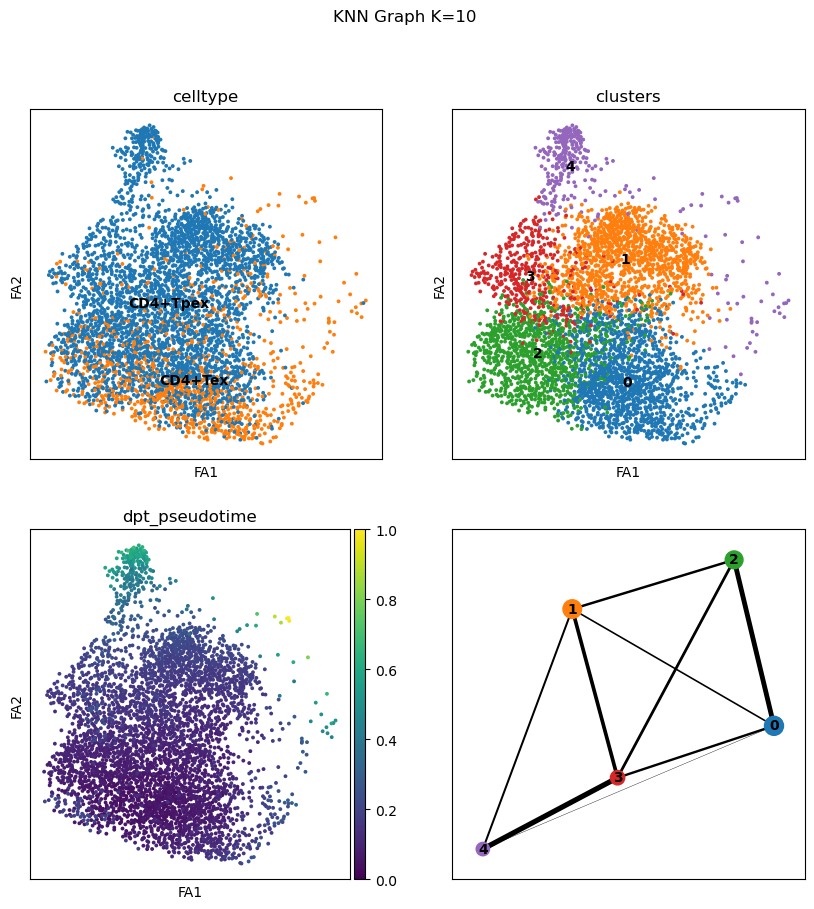

In [6]:
def plotPseudoTime(graph,data,title):
    point_ad = data.copy()
    point_ad.uns['neighbors'] = {"connectivities_key":"connectivities",
                                 "distances_key":"distances"}
    point_ad.obsp['connectivities'] = umap(
                *_get_indices_distances_from_sparse_matrix(graph,10),
                n_obs=ad_data.n_obs,
                n_neighbors=10,
            )
    point_ad.obsp['distances'] = graph
    sc.tl.draw_graph(point_ad)
    sc.tl.leiden(adata=point_ad,resolution=0.5,key_added='clusters')
    root = np.flatnonzero(point_ad.obs['celltype'] == 'CD4+Tex')[0]
    point_ad.uns['iroot'] = root
    #sc.pp.neighbors(point_ad,n_neighbors=20)
    sc.tl.diffmap(point_ad)
    sc.tl.dpt(point_ad)
    fig,axs = plt.subplots(2,2,figsize=(10,10))
    sc.pl.draw_graph(point_ad,color=["celltype"],legend_loc="on data",ax=axs[0,0],show=False)
    sc.pl.draw_graph(point_ad,color=["clusters"],legend_loc="on data",ax=axs[0,1],show=False)
    sc.pl.draw_graph(point_ad,color=["dpt_pseudotime"],legend_loc="on data",ax=axs[1,0],show=False)
    sc.tl.paga(point_ad,groups='clusters')
    sc.pl.paga(point_ad,ax=axs[1,1],show=False)
    fig.suptitle(title)
    return fig

for graph, title in [(min_curv_graph,'Min Curvature'),(max_curv_graph,'Max Curvature'),(knn_graph,'KNN Graph K=30'),(knn_graph_small,'KNN Graph K=10')]:
    plotPseudoTime(graph,ad_data,title)